In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.7.0+cu110
Populating the interactive namespace from numpy and matplotlib


## Pandas Datareader Test

In [2]:
start = (2000, 12 ,1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('028050.KS', 'yahoo', start, end)

<class 'pandas.core.frame.DataFrame'>


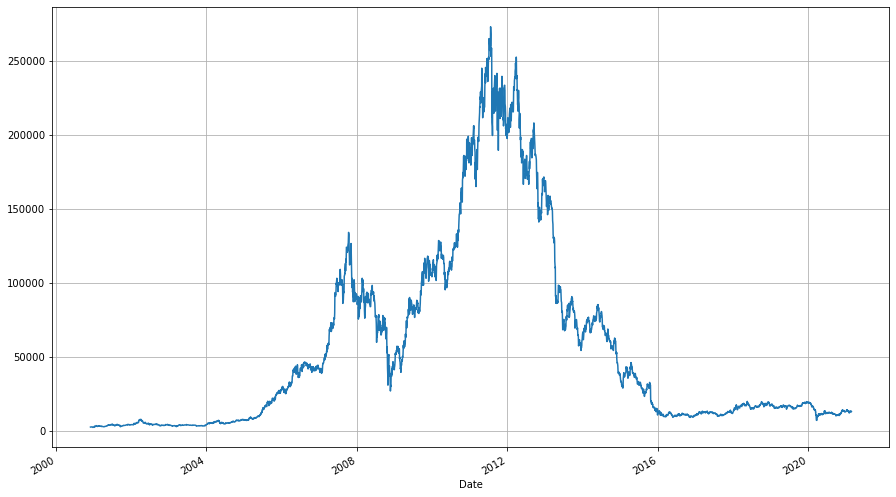

In [3]:
google.Low.plot(grid=True)
print(type(google))

In [4]:
google

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-12-01,2500.0,2420.0,2495.0,2500.0,222800.0,1927.813110
2000-12-04,2560.0,2450.0,2500.0,2470.0,196100.0,1904.679199
2000-12-05,2500.0,2455.0,2455.0,2485.0,158800.0,1916.245728
2000-12-06,2580.0,2490.0,2530.0,2490.0,287600.0,1920.101562
2000-12-07,2490.0,2455.0,2470.0,2465.0,147900.0,1900.823608
...,...,...,...,...,...,...
2021-02-16,13600.0,13250.0,13500.0,13300.0,1059711.0,13300.000000
2021-02-17,13250.0,13000.0,13250.0,13100.0,1185917.0,13100.000000
2021-02-18,13250.0,12900.0,13100.0,12900.0,1045047.0,12900.000000


## Data Preparation

In [76]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)
        
        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        print(self.data.isna().sum())      
    
    
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        
        # data normalization
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values    # dataframe to np.array
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [78]:
dataset = StockDataset('028050.KS', 10, 5, (2001, 1, 1), (2005, 1, 1))
dataloader = DataLoader(dataset, 2, drop_last = True, shuffle = True)

for X, y in dataloader:
    print(X.shape, y.shape)
    break

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


## Model Define